In [211]:
import cv2
import matplotlib.pyplot as plt
import pprint
import numpy as np
from PIL import Image
import io
import easyocr

In [212]:
reader = easyocr.Reader(['en'])

Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% Complete

In [44]:
# When you upload an image to a Flask API, it is usually read as a byte stream. 
# We can access the uploaded file as bytes using request.files['file'].read() in Flask route.
def read_image(img_path):
    pprint.pprint("Reading image as bytes")
    with open(img_path, "rb") as img:
        image_bytes = img.read()
    pprint.pprint(f"Done reading image bytes. {type(image_bytes)}")
    return image_bytes

In [45]:
# Using Image.open(io.BytesIO(img_bytes)) is a common and correct way to convert image bytes back into an image object using the PIL library.
# This will allow us to manipulate or display the image.
def change_image_data(img_bytes):
    pprint.pprint("Changing bytes to image data")
    image_data = Image.open(io.BytesIO(img_bytes))
    pprint.pprint(f"Done changing image data. {type(image_data)}")
    return image_data
# Image.open(io.BytesIO(img_bytes)) returns a PIL.Image.Image object, which represents the image and can be manipulated or displayed.

In [56]:
# Using np.array(img_bytes) directly on the byte data is not appropriate because it doesn't interpret the bytes as an image. 
# Instead, it treats them as raw data, which can lead to incorrect results.
# So it's important to convert image bytes to an image object first, before converting to numpy arrays.
def change_np_array(img_bytes):
    pprint.pprint("Changing bytes to np arrays")
    image_array = np.array(img_bytes)
    pprint.pprint(f"Done changing np arrays. {type(image_array)}")
    print("Image shape:", image_array.shape)
    print("Image dtype:", image_array.dtype)
    return image_array
# np.array(img) (where img is a PIL.Image.Image object) converts the image into a NumPy array, where the data is represented as a 3D array (height, width, color channels).

In [286]:
def show_images(main_image_np, main_image_title="Input Image", other_images=[]):
    """
    Display the main image in a separate plot and additional images using subplots.

    :param main_image_np: NumPy array of the main image.
    :param images_info: List of dictionaries containing 'name' and 'data' for each additional image.
    """
    # Plot the main image separately
    plt.figure(figsize=(5, 5))
    plt.imshow(main_image_np, cmap='gray')
    plt.title(main_image_title)
    # plt.axis('off')
    plt.show()

    # Total number of additional images
    num_other_images = len(other_images)

    # Calculate number of rows needed (3 images per row)
    num_rows = (num_other_images + 2) // 3

    # Plot additional images in subplots
    plt.figure(figsize=(15, 5 * num_rows))

    for idx, other_image in enumerate(other_images, start=1):
        plt.subplot(num_rows, 3, idx)
        plt.imshow(other_image['data'], cmap='gray')
        plt.title(other_image.get('name', "No Title"))
        # plt.axis('off')

    # Adjust layout to ensure titles and images are not overlapping
    plt.tight_layout()
    plt.show()

In [277]:
image_bytes = read_image("cropped.jpg")

'Reading image as bytes'
"Done reading image bytes. <class 'bytes'>"


'Changing bytes to image data'
"Done changing image data. <class 'PIL.JpegImagePlugin.JpegImageFile'>"


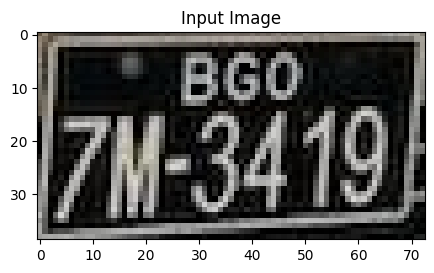

<Figure size 1500x0 with 0 Axes>

In [278]:
image_data = change_image_data(image_bytes)
show_images(image_data)

'Changing bytes to np arrays'
"Done changing np arrays. <class 'numpy.ndarray'>"
Image shape: (39, 73, 3)
Image dtype: uint8


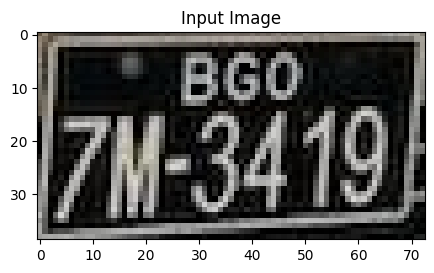

<Figure size 1500x0 with 0 Axes>

In [279]:
image_np = change_np_array(image_data)
show_images(image_np)

In [224]:
# Convert the image to a grayscale NumPy array
def gray_scale(image_np, quiet=True):
    if len(image_np.shape) == 2:
        _gray_image_np = image_np
    else:
        _gray_image_np = cv2.cvtColor(image_np, cv2.COLOR_RGB2GRAY)
    if not quiet: show_images(image_np, [{"name": "GrayScaled", "data": _gray_image_np}])
    return _gray_image_np

In [225]:
# Convert the image to a grayscale NumPy array because cv2.equalizeHist() works only on single-channel images.
def equalize(image_np, quiet=True):
    _equalized_image_np = cv2.equalizeHist(image_np)
    if not quiet: show_images(image_np, [{"name": "Equalized", "data": _equalized_image_np}])
    return _equalized_image_np

In [226]:
# Adaptive thresholding can help in binarizing the image, which is useful for distinguishing text from the background.
def adaptive_thresh(image_np, quiet=True):
    _binary_image_np = cv2.adaptiveThreshold(
        image_np, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2
    )
    if not quiet: show_images(image_np, [{"name": "Binary", "data": _binary_image_np}])
    return _binary_image_np

In [227]:
# Reducing noise in the image can enhance the clarity of the text. Use Gaussian or median filtering for this purpose.
def blur(image_np, quiet=True):
    _blurred_image_np = cv2.GaussianBlur(image_np, (5, 5), 0)
    if not quiet: show_images(image_np, [{"name": "Blurred", "data": _blurred_image_np}])
    return _blurred_image_np

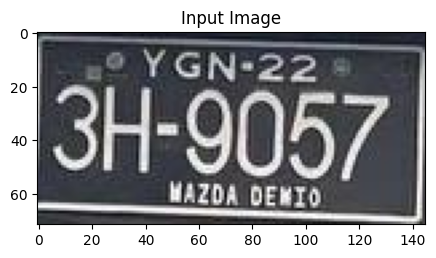

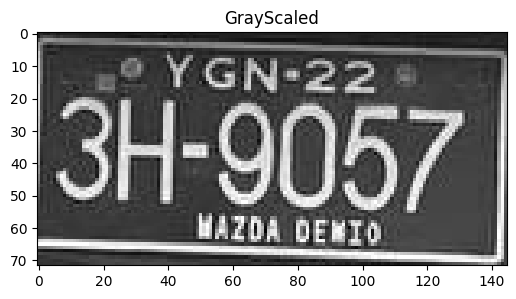

In [257]:
# Converting the image to grayscale simplifies the image by reducing color information, making it easier for OCR algorithms to focus on the text.
grayscaled_image_np = gray_scale(image_np, False)

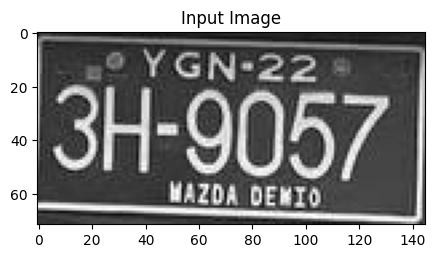

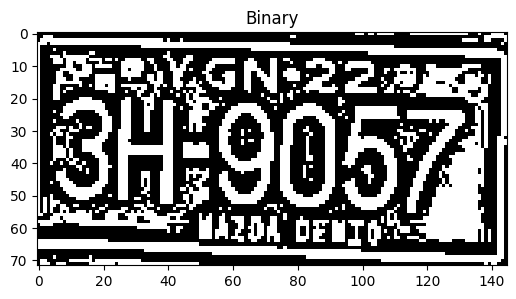

In [258]:
# Apply Adaptive Thresholding
binary_image_np = adaptive_thresh(grayscaled_image_np, False)

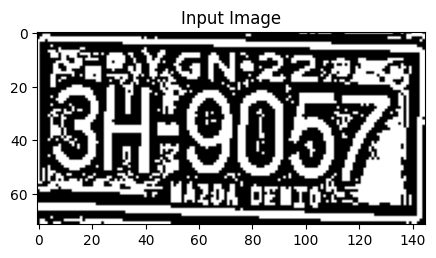

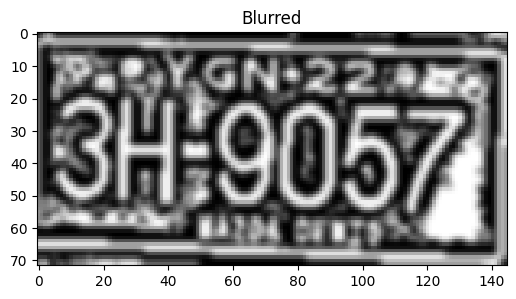

In [259]:
# Denoise the Image
blurred_image_np = blur(binary_image_np, False)

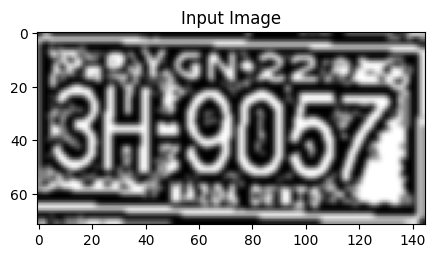

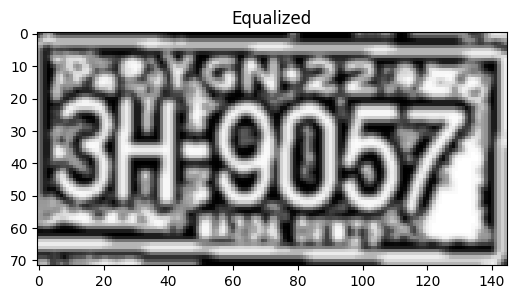

In [260]:
# Increase Contrast
equalized_image_np = equalize(blurred_image_np, False)

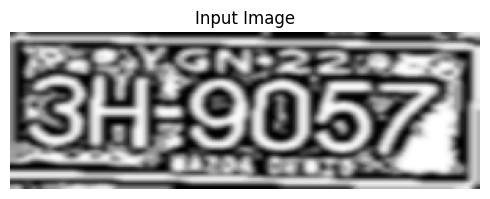

In [261]:
resized_image = cv2.resize(equalized_image_np, (300, 100))
show_image(resized_image)

In [264]:
result = reader.readtext(image_np)
for detection in result:
    print(detection[1])

GN-22
3H-9057
MAZDA DELIO


In [249]:
result = reader.readtext(gray_scaled_image_np)
for detection in result:
    print(detection[1])

GN22 0
BE-6293
E4o
DENID


In [265]:
result = reader.readtext(binary_image_np)
for detection in result:
    print(detection[1])

'220
905
'Eolg


In [266]:
result = reader.readtext(blurred_image_np)
for detection in result:
    print(detection[1])

3H.9057


In [267]:
result = reader.readtext(equalized_image_np)
for detection in result:
    print(detection[1])

33H905


In [268]:
result = reader.readtext(resized_image)
for detection in result:
    print(detection[1])

3H905


'Reading image as bytes'
"Done reading image bytes. <class 'bytes'>"
'Changing bytes to image data'
"Done changing image data. <class 'PIL.JpegImagePlugin.JpegImageFile'>"
'Changing bytes to np arrays'
"Done changing np arrays. <class 'numpy.ndarray'>"
Image shape: (70, 164, 3)
Image dtype: uint8


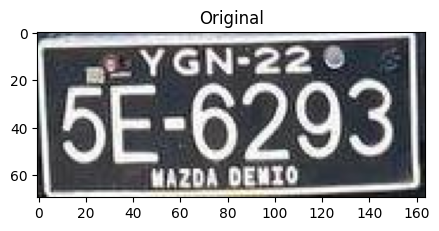

<Figure size 1500x0 with 0 Axes>

YGN22 0
0.41762114767027575
BE-6293
0.4938383827430406
E4o
0.0017611953106552362
DENID
0.6440591193990731


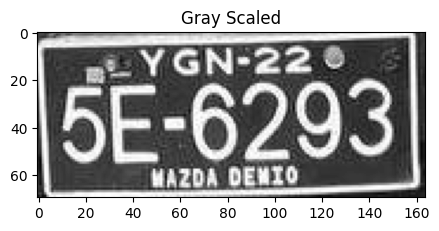

<Figure size 1500x0 with 0 Axes>

GN22 0
0.49310448556790015
BE-6293
0.5049627573564224
E4o
0.0017672613620886013
DENID
0.6387609665717083


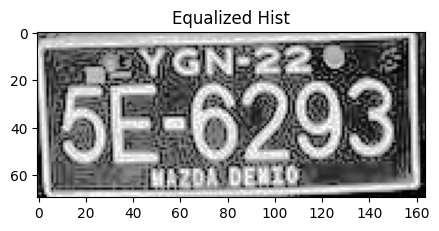

<Figure size 1500x0 with 0 Axes>

G*2
0.20100154457115826
5E.6293
0.6162538018903898


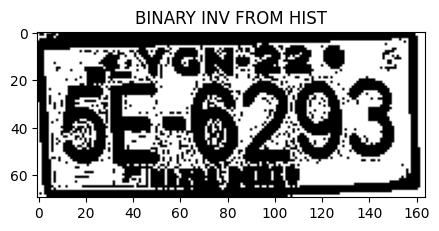

<Figure size 1500x0 with 0 Axes>

93
0.9333717127968972


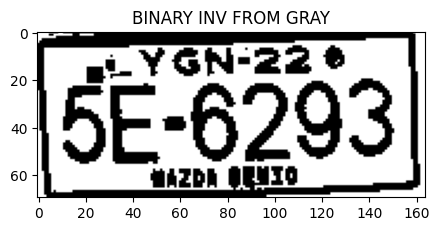

<Figure size 1500x0 with 0 Axes>

GN22
0.28965359926223755
5E.6293
0.3430407576665028
Fd
0.010899382193712346


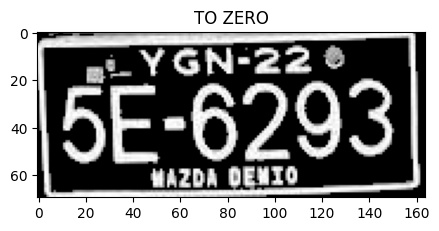

<Figure size 1500x0 with 0 Axes>

GN-22
0.9543837294895539
5E.6293
0.7580606910928499
F4e
0.0021363187090770747
DENID
0.07033529811315183


In [288]:
image_bytes = read_image("cropped.jpg")
image_data = change_image_data(image_bytes)
image_np = change_np_array(image_data)

show_images(image_np, "Original")
result = reader.readtext(image_np)
for detection in result:
    print(detection[1])
    print(detection[2])

image_gray = cv2.cvtColor(image_np, cv2.COLOR_RGB2GRAY)
show_images(image_gray, "Gray Scaled")
result = reader.readtext(image_gray)
for detection in result:
    print(detection[1])
    print(detection[2])
    
image_hist = cv2.equalizeHist(image_gray)
show_images(image_hist, "Equalized Hist")
result = reader.readtext(image_hist)
for detection in result:
    print(detection[1])
    print(detection[2])

_, image_bin_thresh = cv2.threshold(image_hist, 120, 255, cv2.THRESH_BINARY_INV) 
show_images(image_bin_thresh, "BINARY INV FROM HIST")
result = reader.readtext(image_bin_thresh)
for detection in result:
    print(detection[1])
    print(detection[2])

_, image_bin_thresh = cv2.threshold(image_gray, 120, 255, cv2.THRESH_BINARY_INV) 
show_images(image_bin_thresh, "BINARY INV FROM GRAY")
result = reader.readtext(image_bin_thresh)
for detection in result:
    print(detection[1])
    print(detection[2])

_, image_bin_thresh = cv2.threshold(image_gray, 120, 255, cv2.THRESH_TOZERO) 
show_images(image_bin_thresh, "TO ZERO")
result = reader.readtext(image_bin_thresh)
for detection in result:
    print(detection[1])
    print(detection[2])